In [38]:
import numpy as np
import torch 
import pickle
import matplotlib.pyplot as plt

In [39]:
def get_metrics(results):
    
    metrics_dict={}

    for seed in results.keys():
        
        result_seed=results[seed]
        cpe_weights=list(result_seed.keys())

        n_train, n_post_samples=result_seed[cpe_weights[0]][0].shape

        
        metrics_dict[seed]={}
        
        metrics_dict[seed]["nll_gibbs_train"]=[]
        metrics_dict[seed]["nll_gibbs_test"]=[]
        metrics_dict[seed]["nll_bayes_train"]=[]
        metrics_dict[seed]["nll_bayes_test"]=[]
        
        metrics_dict[seed]["err_gibbs_train"]=[]
        metrics_dict[seed]["err_gibbs_test"]=[]
        metrics_dict[seed]["err_bayes_train"]=[]
        metrics_dict[seed]["err_bayes_test"]=[]

        metrics_dict[seed]["grad_nll_gibbs"]=[]

        for cpe_weight in cpe_weights:
            
            log_p_train=torch.tensor(result_seed[cpe_weight][0])
            log_p_test=torch.tensor(result_seed[cpe_weight][1])
            
            metrics_dict[seed]["nll_gibbs_train"].append(-log_p_train.mean().item())
            metrics_dict[seed]["nll_gibbs_test"].append(-log_p_test.mean().item())
            
            bayes_loss_train=(torch.log(torch.tensor(n_post_samples)) - torch.logsumexp(log_p_train, 1)).mean().item()
            metrics_dict[seed]["nll_bayes_train"].append(bayes_loss_train)
            bayes_loss_test=(torch.log(torch.tensor(n_post_samples)) - torch.logsumexp(log_p_test, 1)).mean().item()
            metrics_dict[seed]["nll_bayes_test"].append(bayes_loss_test)
            
            grad_expected_gibbs = (
                    -n_train
                    * (
                        (log_p_train.mean(0) * log_p_test.mean(0)).mean()
                        - log_p_test.mean() * log_p_train.mean()
                    ).item()
                )
            metrics_dict[seed]["grad_nll_gibbs"].append(grad_expected_gibbs)

            metrics_dict[seed]["err_gibbs_train"].append(1-np.array(result_seed[cpe_weight][2])[:,1].mean())
            metrics_dict[seed]["err_gibbs_test"].append(1-np.array(result_seed[cpe_weight][3])[:,1].mean())
            metrics_dict[seed]["err_bayes_train"].append(1-np.array(result_seed[cpe_weight][4])[:,1].mean())
            metrics_dict[seed]["err_bayes_test"].append(1-np.array(result_seed[cpe_weight][5])[:,1].mean())

    return metrics_dict

In [40]:
tempering="likelihood"
version_i=1

with open(f'results_{tempering}_{version_i}.pickle', 'rb') as handle:
    results = pickle.load(handle)

metrics=get_metrics(results)
seeds=list(results.keys())
cpe_weights=list(results[seeds[0]].keys())

# in-between seeds

In [41]:
name_metrics=list(metrics[seeds[0]].keys())

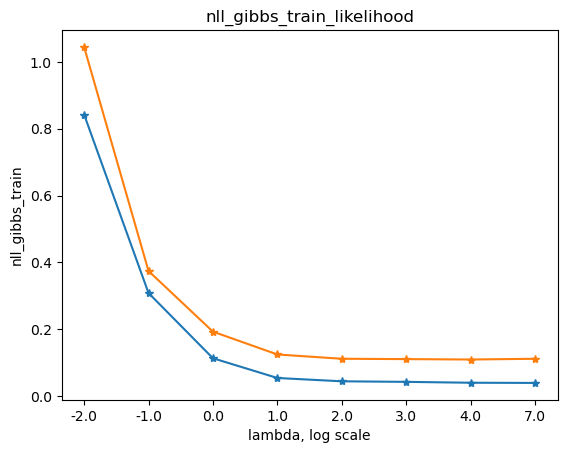

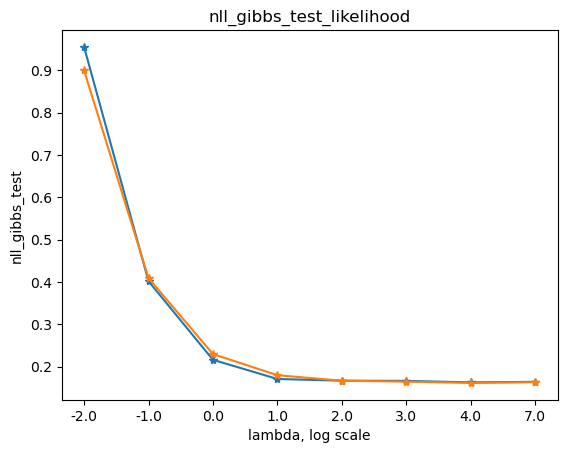

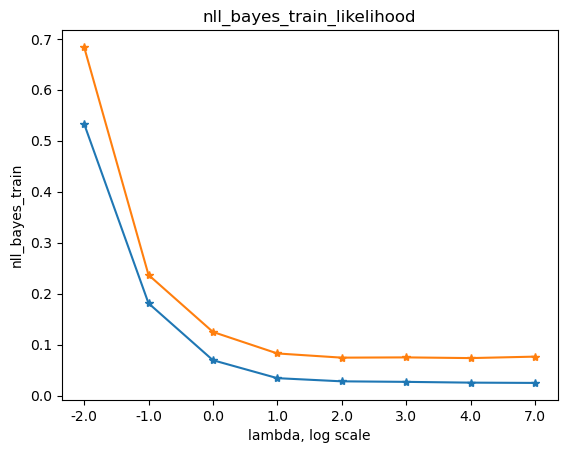

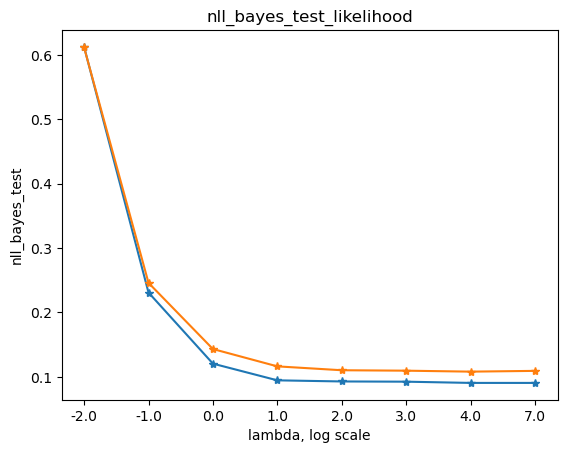

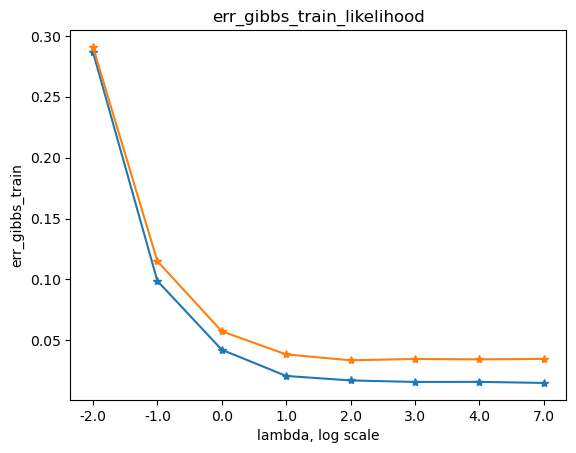

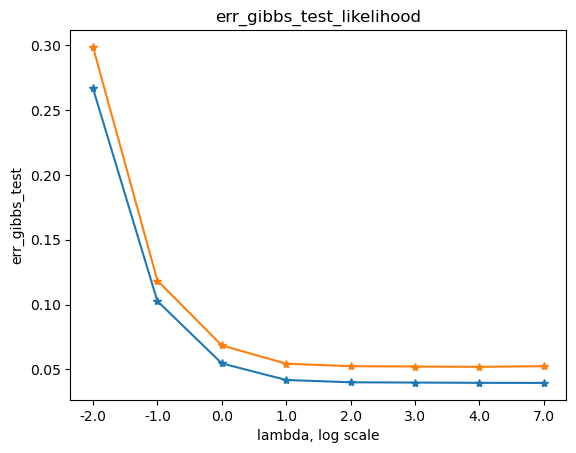

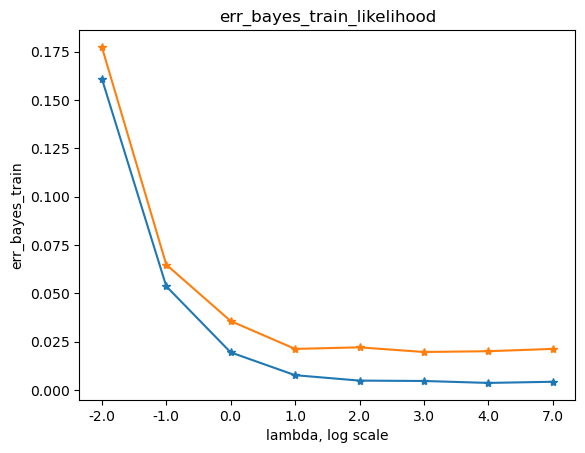

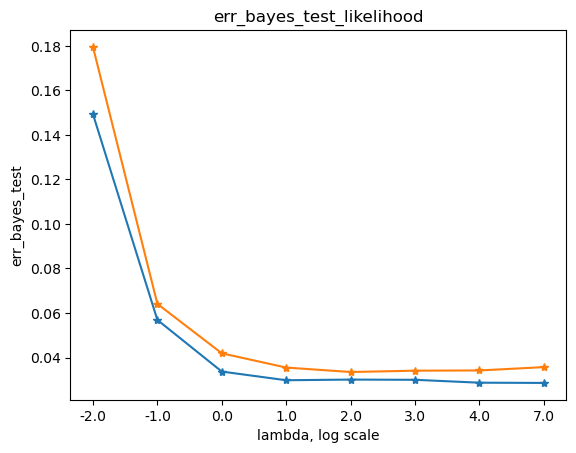

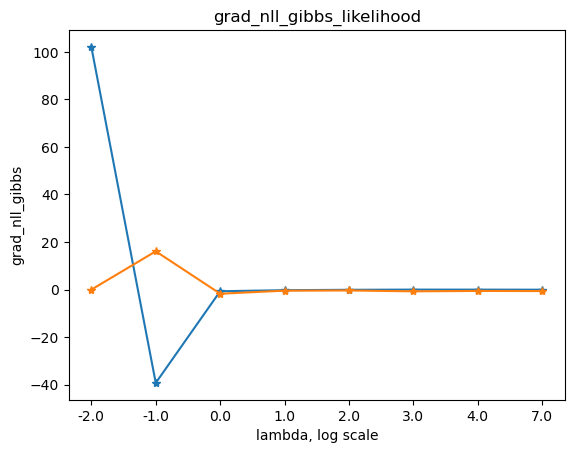

In [42]:
for name_metric in name_metrics:
    save_name=f"{name_metric}_{tempering}"
    plt.figure()
    plt.title(save_name)
    for seed in seeds:
        plt.plot(np.arange(0,len(cpe_weights),1),metrics[seed][name_metric], marker="*")
    # plt.plot(np.arange(0,len(lambs),1),nll_gibbs_test_1, marker="*", label=prior_scale_1)

    plt.xticks(np.arange(0,len(cpe_weights),1), np.log10(cpe_weights))
    # plt.legend()
    if tempering=="likelihood":
        plt.xlabel("lambda, log scale")
    if tempering=="prior":
        plt.xlabel("gamma, log scale")
    plt.ylabel(name_metric)
    # plt.ylim(0,0.1)
    plt.savefig(f"./between seeds/{tempering}/{save_name}.png", dpi=300)
    plt.show()

# main plots

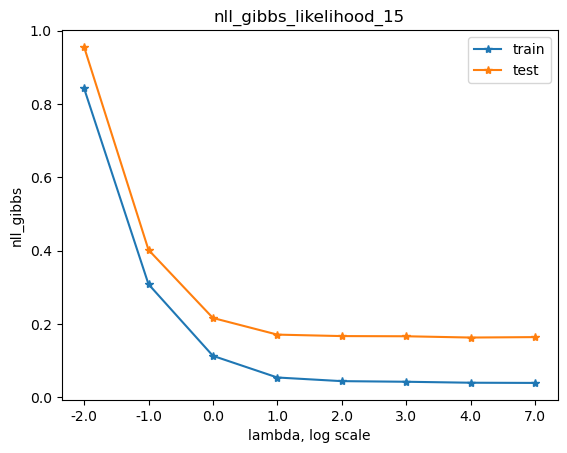

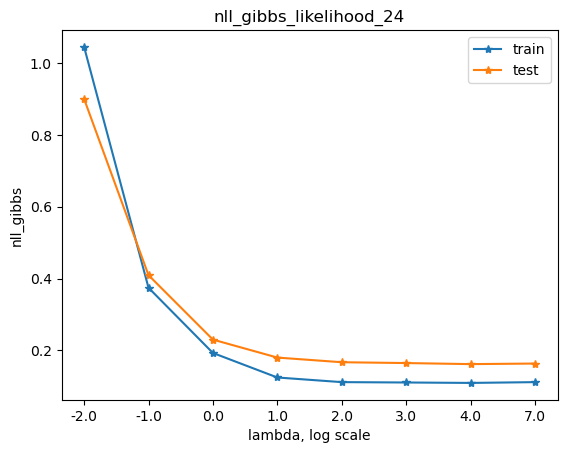

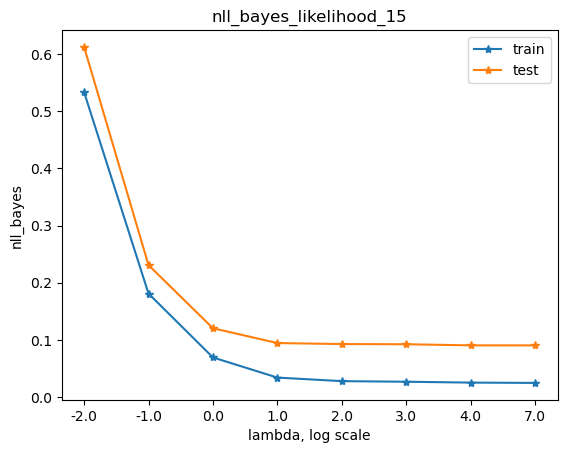

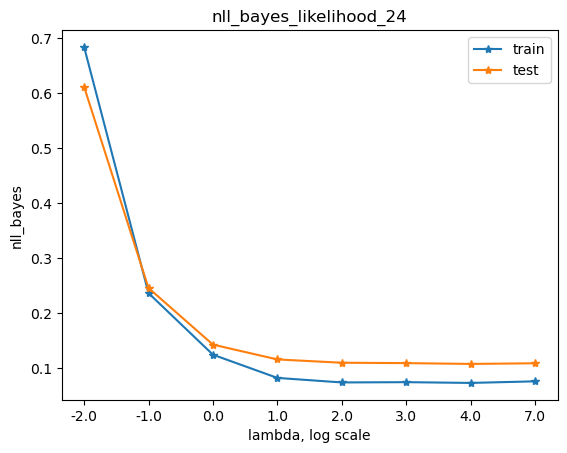

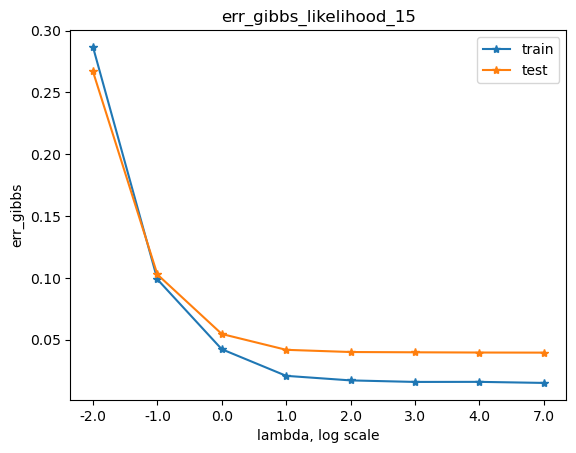

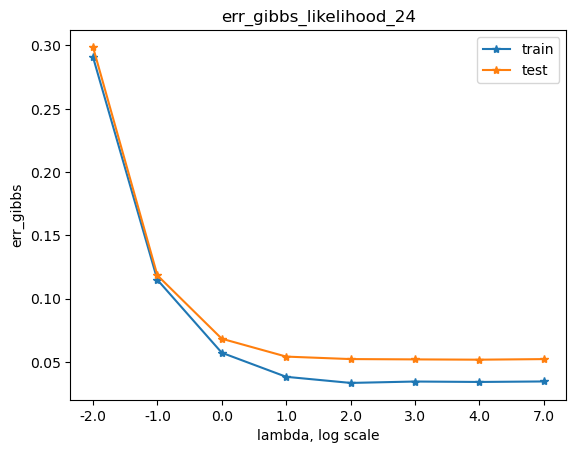

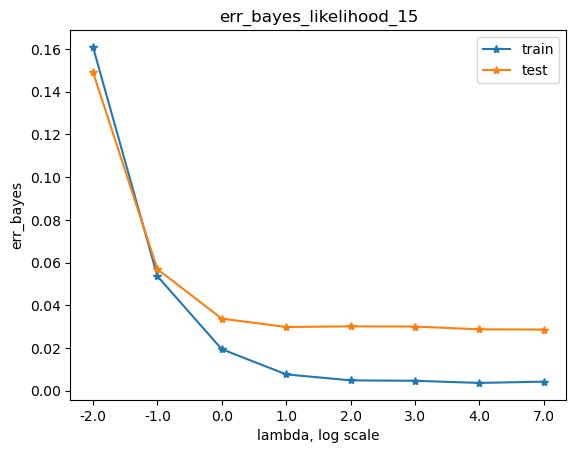

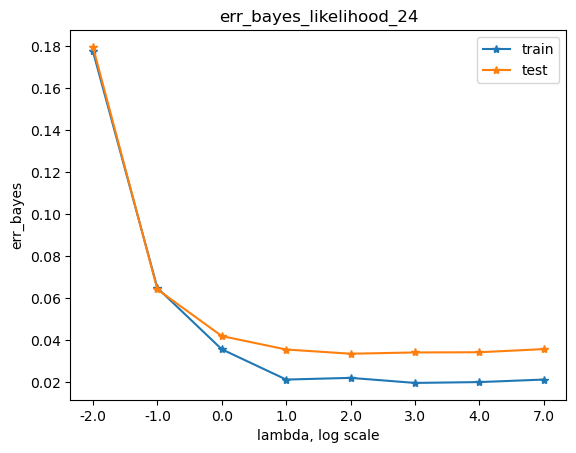

In [43]:
name_metrics=["nll_gibbs","nll_bayes","err_gibbs","err_bayes"]
for name_metric in name_metrics:
    for seed in seeds:
        plt.figure()
        save_name=f"{name_metric}_{tempering}_{seed}"
        plt.title(save_name)
        plt.plot(np.arange(0,len(cpe_weights),1),metrics[seed][f"{name_metric}_train"], marker="*", label="train")
        plt.plot(np.arange(0,len(cpe_weights),1),metrics[seed][f"{name_metric}_test"], marker="*", label="test")
        # plt.plot(np.arange(0,len(lambs),1),nll_gibbs_test_1, marker="*", label=prior_scale_1)

        plt.xticks(np.arange(0,len(cpe_weights),1), np.log10(cpe_weights))
        # plt.legend()
        if tempering=="likelihood":
            plt.xlabel("lambda, log scale")
        if tempering=="prior":
            plt.xlabel("gamma, log scale")
        plt.ylabel(name_metric)
        plt.legend()
        plt.savefig(f"./main/{tempering}/seed_{seed}/{save_name}.png", dpi=300)
        plt.show()